# Analyse data for line loop navigation coming from the homecage 

In [359]:
%matplotlib inline

import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import scipy.stats as stt
import pandas as pd
from datetime import datetime
import matplotlib
import networkx as nx

In [330]:
#physical positions of the pokes
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

##  Main function to analyse probe trial performance

In [21]:
df = pd.DataFrame(columns=['subject','time','seq','graph_type','two_tasks','nRews','probe_dict'])

In [22]:
def get_experiment_name(line):
    return re.findall('Experiment name[\s] \: (.*)\n',line)[0]

def get_subject_name(line):
    return re.findall('Subject ID[\s]:[\s](.*)\n',line)[0]

def get_start_date(line):
    return re.findall('Start date[\s]:[\s](.*)\n',line)[0]

In [234]:
def get_probe_trial_performance_homecage(lines):
    """ NEED TO UPDATE THIS TO INCLUDE TIME LIMIT"""
    times = []
    probe_perf = []
    target_hist = []; probe_hist = []; poked_hist = []; dir_hist = []; seq_hist = []

    task_nums = []
    info_dict = {}
    probe_dict = {}
    all_info_dicts = [] #this is for when there are two tasks in one session
    seq = None
    task_number = None
    for ix,l_ in enumerate(lines[:-1]):
        
        if 'Subject ID' in l_: info_dict['subject'] = get_subject_name(l_)
        if 'Experiment name' in l_: info_dict['exp_name'] = get_experiment_name(l_)
        if 'Start date' in l_: info_dict['date'] = get_start_date(l_)
            
        
        if 'task_number' in l_:
            if len(task_nums)>0:
                info_dict['seq'] = seq
                info_dict['task_nr'] = task_number
                info_dict['probe_dict'] = probe_dict.copy()
                info_dict['len_seq'] = None if seq is None else len(seq)
                all_info_dicts.append(info_dict.copy())
                info_dict = info_dict.copy()
                del info_dict['probe_dict']
                

                #print(task_number)
                probe_dict = {}
            task_number = int(re.findall('task_number([0-9])',l_)[0])
            task_nums.append(task_number)
            
        if 'seq' in l_:
            seq = eval(re.findall('seq:(\[.*\])', l_)[0])
            
        if 'TARGET:' in l_:
            t_ = re.findall('P ([0-9]*) R',l_)[0]
            times.append(float(t_))
            probe = eval(re.findall('PROBE: (False|True)',l_)[0])
            target = int(re.findall('TARGET: ([0-9]*)',l_)[0])
            poked = int(re.findall('POKED: ([0-9]*)',l_)[0])
            direction = int(re.findall('DIR: (.*)',l_)[0])
            seq_ix = int(re.findall('SEQ_IX: ([0-9]*)',l_)[0])
            if seq_hist:
                if probe:
                    #print(target)
                    if not (probe_hist[-1] and (target==target_hist[-1])):
                        correct_poke = poked==target
                        probe_perf.append(correct_poke)
                        transition = str(target_hist[-1]) + '_' + str(target)

                        if transition in probe_dict.keys():
                            probe_dict[transition].append(correct_poke)
                        else:
                            probe_dict[transition] = [correct_poke]
                            
                       

            target_hist.append(target); probe_hist.append(probe); dir_hist.append(direction);
            poked_hist.append(poked); seq_hist.append(seq_ix)
    #print(len(probe_perf))
    info_dict['seq'] = seq; info_dict['task_nr'] = task_number; info_dict['probe_dict'] = probe_dict.copy()
    info_dict['len_seq'] = None if seq is None else len(seq)
    all_info_dicts.append(info_dict)
    if len(task_nums)>1:
        print(task_nums)
    return all_info_dicts

In [235]:
a = {}


In [236]:
a.copy()

{}

##  Loop analysis over all subjects

In [305]:
experiment_folders = [r"/Users/yves/Downloads/ec_lineloop_1/",
                     r"/Users/yves/Downloads/ec_lineloop_2/"]

subject_folders = []
for ef in experiment_folders:
    sf1 = os.listdir(ef)
    
    for sf_ in sf1:
        sf = os.path.join(ef,sf_)
        #print(sf)
        #if sf=='/Users/yves/Downloads/ec_lineloop_2/.DS_Store':
        #|print('.DS' in sf)
        if not ('.DS' in sf):
            fold2 = [i for i in os.listdir(sf) if '.DS' not in i][0]
            subject_folders.append(os.path.join(sf,fold2))


In [306]:
'.DS' in '/Users/yves/Downloads/ec_lineloop_2/.DS_Store'

True

In [307]:
subject_folders

['/Users/yves/Downloads/ec_lineloop_1/C00494062_4/16190096674466636_task',
 '/Users/yves/Downloads/ec_lineloop_1/C00494062_3/16190096502200105_task',
 '/Users/yves/Downloads/ec_lineloop_1/C00494062_2/1619009637253015_task',
 '/Users/yves/Downloads/ec_lineloop_1/C00494062_5/16190096773636293_task',
 '/Users/yves/Downloads/ec_lineloop_1/C00494062_1/16190095855355382_task',
 '/Users/yves/Downloads/ec_lineloop_2/C00499495_3/16201231194133265_task',
 '/Users/yves/Downloads/ec_lineloop_2/C00499495_4/1620123129700262_task',
 '/Users/yves/Downloads/ec_lineloop_2/C00499495_5/1620123140332491_task',
 '/Users/yves/Downloads/ec_lineloop_2/C00499495_2/16201231071871436_task',
 '/Users/yves/Downloads/ec_lineloop_2/C00499495_1/16201230948022072_task',
 '/Users/yves/Downloads/ec_lineloop_2/C00499495_6/16201231547824955_task']

In [308]:
#How will it be easiest to store this data?

df = pd.DataFrame(columns=['subject','exp_name', 'date', 'seqs', 'task_nr', 'probe_dict', 'len_seq'])

In [309]:
def merge_dicts(*dict_args):
    """
    Given any number of dictionaries, shallow copy and merge into a new dict,
    precedence goes to key-value pairs in latter dictionaries.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

In [310]:
def build_df(subject_folders):
    """
    Here we loop through the subject folders and get a list of all sessions
    that is annotated with some metadata
    
    Arguments:
    =========================================
    
    subject_folders (list): list of folders where each folder contains the
                            data files for one subject
                            
    
    """
    df = pd.DataFrame(columns=['subject','exp_name', 'date', 'seq', 'task_nr', 'probe_dict', 'len_seq'])
    for ROOT in subject_folders:
        print(ROOT)
        fs = [i for i in os.listdir(ROOT) if '_taskFile' not in i]
        probe_dict = {}
        for f_ in fs:
            if 'follow_the_light_2_graphs' in f_:
                #print(f_)
                fpath = os.path.join(ROOT,f_)
                with open(fpath,'r') as f:
                    lines = f.readlines()

                all_info_dict = get_probe_trial_performance_homecage(lines)
                #print(probe_dict)
                for i in all_info_dict:
                    df = df.append(i,ignore_index=True)
    return df

In [311]:
df = build_df(subject_folders)

/Users/yves/Downloads/ec_lineloop_1/C00494062_4/16190096674466636_task
[0, 1]
[1, 0]
[0, 1]
[1, 0]
/Users/yves/Downloads/ec_lineloop_1/C00494062_3/16190096502200105_task
[1, 0]
[1, 0]
[0, 1]
[0, 1]
[0, 1]
/Users/yves/Downloads/ec_lineloop_1/C00494062_2/1619009637253015_task
[0, 1]
[1, 0]
[0, 1]
/Users/yves/Downloads/ec_lineloop_1/C00494062_5/16190096773636293_task
[0, 1]
[1, 0]
[0, 1]
/Users/yves/Downloads/ec_lineloop_1/C00494062_1/16190095855355382_task
[1, 0]
[0, 1]
[1, 0]
[0, 1]
/Users/yves/Downloads/ec_lineloop_2/C00499495_3/16201231194133265_task
[0, 1]
[1, 0]
[1, 0]
/Users/yves/Downloads/ec_lineloop_2/C00499495_4/1620123129700262_task
[0, 1]
[1, 0]
/Users/yves/Downloads/ec_lineloop_2/C00499495_5/1620123140332491_task
[0, 1]
[1, 0]
/Users/yves/Downloads/ec_lineloop_2/C00499495_2/16201231071871436_task
/Users/yves/Downloads/ec_lineloop_2/C00499495_1/16201230948022072_task
[1, 0]
[0, 1]
/Users/yves/Downloads/ec_lineloop_2/C00499495_6/16201231547824955_task
[1, 0]
[0, 1]


In [312]:
df

,subject,exp_name,date,seq,task_nr,probe_dict,len_seq
0,C00494062_4,ec_lineloop_1,2021-05-10-222525,"[0, 4, 5]",1,{},3
1,C00494062_4,ec_lineloop_1,2021-05-10-214450,"[0, 4, 5]",1,"{'0_5': [False], '4_5': [False], '5_4': [False]}",3
2,C00494062_4,ec_lineloop_1,2021-05-11-024020,"[0, 4, 5]",1,{},3
3,C00494062_4,ec_lineloop_1,2021-05-10-130945,"[8, 1, 6]",0,"{'1_6': [True], '8_1': [False], '6_1': [False,...",3
4,C00494062_4,ec_lineloop_1,2021-05-10-173501,"[0, 4, 5]",1,"{'0_5': [False, False]}",3
...,...,...,...,...,...,...,...
416,C00499495_6,ec_lineloop_2,2021-05-07-131309,None,None,{},None
417,C00499495_6,ec_lineloop_2,2021-05-11-004937,"[3, 6, 1]",0,{},3
418,C00499495_6,ec_lineloop_2,2021-05-10-233746,"[3, 6, 1]",0,"{'1_6': [True, True, True, True, True, True], ...",3
419,C00499495_6,ec_lineloop_2,2021-05-10-230505,"[3, 6, 1]",0,"{'3_1': [False, True], '1_6': [True], '6_1': [...",3


In [313]:
def merge_dicts(x):
    out = {}
    for d in x.dropna():
        for k,v in d.items():
            if k not in out.keys():
                out[k] = v
            else:
                out[k].extend(v)
    #for k,v in out.items():
    #    if 
    #    out[k] = [item for sublist in v for item in sublist]
    return out


In [314]:
grouped= df.groupby(['subject','task_nr'])

In [315]:
mergag = grouped['probe_dict'].agg(merge_dicts)

In [354]:
subj

'C00499495_6'

In [353]:
probe_trials

{'7_0': [False, False, False, False, False],
 '4_0': [True, False, True, False, True, False],
 '7_4': [True, False, False, True, False, False],
 '0_4': [True, True, True, False, True],
 '0_7': [False, False, False, False, False, False, False],
 '4_7': [False]}

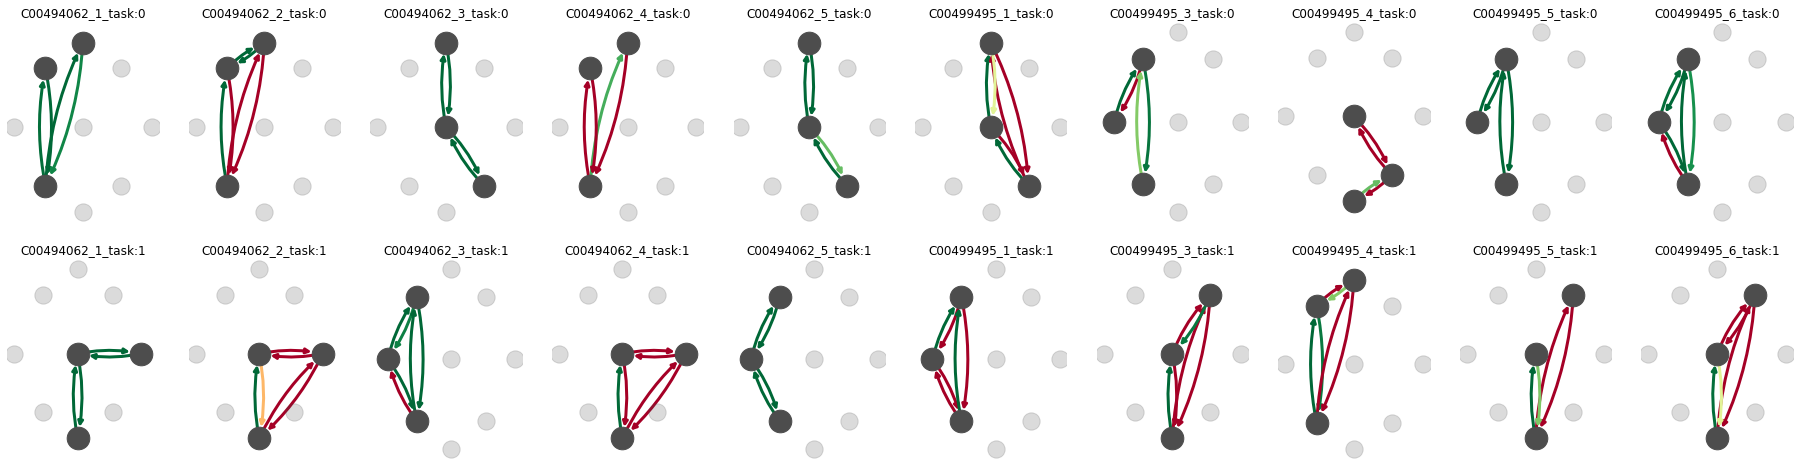

In [363]:
plt.figure(figsize=(32,8))
ctr = 0
subplot_pos = [val+1 for pair in zip(range(10), range(10,20)) for val in pair]

for (subj,task), probe_trials in mergag.iteritems():
    plt.subplot(2,10,subplot_pos[ctr])
    plt.title('_'.join([subj,'task:{}'.format(str(task))]))
    make_plot(probe_trials,color='pval',mx=0.05)
    
    
    ctr+=1

In [362]:
def make_plot(res_dict,mx=1,color='mean'):
    #plt.figure(figsize=(12,4))


#    mx = 1
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
    nx.draw(G0,pos=poke_pos,alpha=.2,node_color='.3')


    G = nx.DiGraph()
    for k,v in res_dict.items():
        if color=='pval':
            c = stt.binom_test(np.sum(v),len(v),p=1/9.)
        else:
            c= np.mean(v)
        G.add_edge(int(k[0]),int(k[-1]),color=cmap.to_rgba(c))

    colors = nx.get_edge_attributes(G,'color')

    nx.draw(G,
            pos=poke_pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=512,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if c

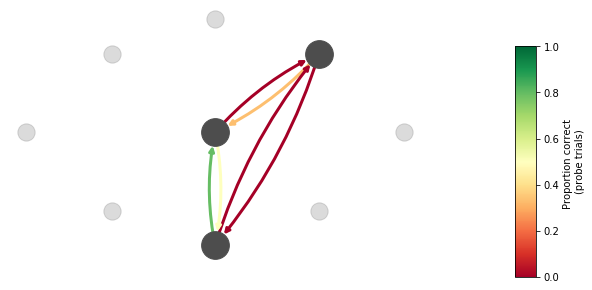

In [337]:
import matplotlib
import networkx as nx
make_plot(probe_trials)